In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.ticker import LogLocator, FuncFormatter

#### Submission & Comments Count Statistics
------

In [2]:
base_dir = '../posts_categorization/linked_submissions_comments'
save_dir = '../posts_categorization/concatenated_linked_datasets'
os.makedirs(save_dir, exist_ok=True)

In [3]:
suicide_dfs = []
depression_dfs = []

for filename in tqdm(os.listdir(base_dir), desc='Processing files'):
    if filename.endswith(".csv"):
        filepath = os.path.join(base_dir, filename)
        if "suicide" in filename:
            suicide_dfs.append(pd.read_csv(filepath, dtype=str, encoding='utf-8', lineterminator='\n'))
        elif "depression" in filename:
            depression_dfs.append(pd.read_csv(filepath, dtype=str, encoding='utf-8', lineterminator='\n'))
        else:
            print("Error: Non-relevant datasets.")

concatenated_suicide_linked = pd.concat(tqdm(suicide_dfs, desc="Concatenating suicide data"), ignore_index=True)
concatenated_depression_linked = pd.concat(tqdm(depression_dfs, desc="Concatenating depression data"), ignore_index=True)

concatenated_suicide_linked = concatenated_suicide_linked.drop(concatenated_suicide_linked.columns[0], axis=1)
concatenated_depression_linked = concatenated_depression_linked.drop(concatenated_depression_linked.columns[0], axis=1)

linked_suicide_save_path = os.path.join(save_dir, "concatenated_suicide_linked.csv")
linked_depression_save_path = os.path.join(save_dir, "concatenated_depression_linked.csv")

concatenated_suicide_linked.to_csv(linked_suicide_save_path, index=False)
concatenated_depression_linked.to_csv(linked_depression_save_path, index=False)

Concatenating depression data: 100%|██████████| 2/2 [00:00<00:00, 43464.29it/s]


In [4]:
def analyze_submission_comment_distributions(dataframe, subreddit_name):
    unique_submissions = dataframe[['submitter_username', 'content_submission', 'thread_id']].drop_duplicates()
    total_submissions = unique_submissions.shape[0]

    unique_comments = dataframe[['commenter_username', 'content_comment', 'thread_id']]
    total_comments = unique_comments.shape[0]

    submission_counts = unique_submissions.groupby('thread_id').size().reset_index(name='submission_count')
    comment_counts = unique_comments.groupby('thread_id').size().reset_index(name='comment_count')

    merged_counts = pd.merge(submission_counts, comment_counts, on='thread_id', how='left').fillna(0)

    # Bin the number of comments into ranges (e.g., 0-10, 11-20, etc.)
    merged_counts['comment_bin'] = pd.cut(merged_counts['comment_count'], bins=np.arange(0, 101, 10), right=False)

    # Group by the comment bins and count the number of submissions in each bin
    comment_distribution = merged_counts.groupby('comment_bin').size().reset_index(name='num_submissions')

    plt.figure(figsize=(8, 6))
    plt.bar(comment_distribution.index, comment_distribution['num_submissions'], color='#CCCCCC', width=0.5)
    plt.yscale('log')
    plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0], numticks=10))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
    plt.xticks(comment_distribution.index, comment_distribution['comment_bin'].astype(str), rotation=45, ha='right')

    plt.title(f'\\r {subreddit_name}', fontweight='bold', fontsize=18)
    plt.xlabel('Number of Responses per Submission (Binned)', fontweight='bold', fontsize=14)
    plt.ylabel('Number of Submissions', fontweight='bold', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'distribution_charts/comment_distribution_{subreddit_name}.png', dpi=300)
    plt.show()

    print(f"Total number of submissions: {total_submissions}")
    print(f"Total number of response: {total_comments}")

/var/folders/3v/sfyw16_d61s8bzc_gdkq0d5h0000gn/T/ipykernel_15601/3326170762.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comment_distribution = merged_counts.groupby('comment_bin').size().reset_index(name='num_submissions')


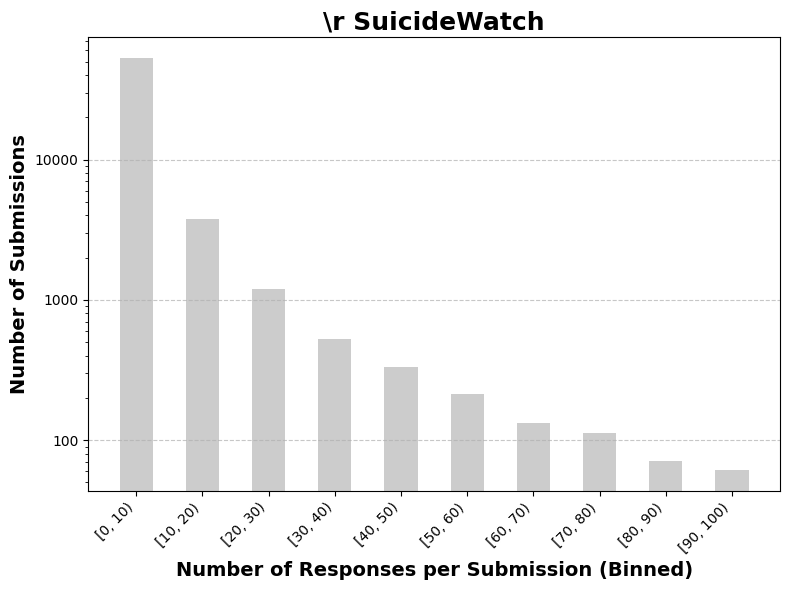

Total number of submissions: 59627
Total number of response: 315464


In [5]:
analyze_submission_comment_distributions(concatenated_suicide_linked, 'SuicideWatch')

/var/folders/3v/sfyw16_d61s8bzc_gdkq0d5h0000gn/T/ipykernel_15601/3326170762.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comment_distribution = merged_counts.groupby('comment_bin').size().reset_index(name='num_submissions')


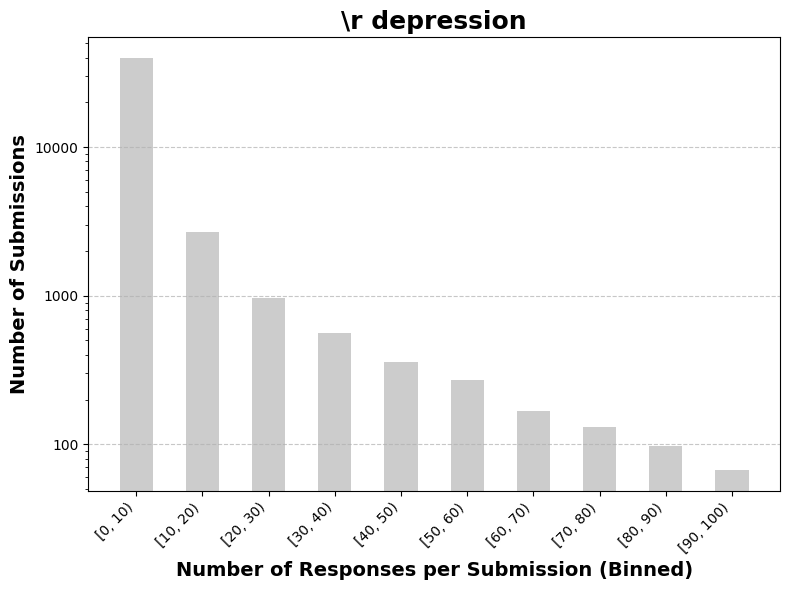

Total number of submissions: 45329
Total number of response: 286745


In [6]:
analyze_submission_comment_distributions(concatenated_depression_linked, 'depression')

In [7]:
def generate_category_statistics(year, subreddit_name, type, categ_methods=['llama', 'gemma', 'qwen']):
    if type == 'submissions':
        if year == 2023 or year == 2024:
            original_df = pd.read_csv(f'linked_submissions_comments/{year}_{subreddit_name}_linked_llama_gemma_qwen.csv', dtype=str, encoding='utf-8', lineterminator='\n')
            original_df = original_df[~original_df[['submitter_username', 'content_submission', 'thread_id']].duplicated()]
        elif year == 'all':
            original_df = pd.read_csv(f'concatenated_linked_datasets/concatenated_{subreddit_name}_linked.csv', dtype=str, encoding='utf-8', lineterminator='\n')
            original_df = original_df[~original_df[['submitter_username', 'content_submission', 'thread_id']].duplicated()]
        else:
            print("Invalid year.")
            return None

        categ_stats_list = []

        for categ_method in categ_methods:
            value_counts = original_df[f'submissions_categ_{categ_method}'].value_counts()

            value_counts_df = value_counts.reset_index()
            value_counts_df.columns = ['submissions_category', f'{categ_method}_submissions_count']

            categ_stats_list.append(value_counts_df)

        categ_stats_merged = categ_stats_list[0]
        for df in categ_stats_list[1:]:
            categ_stats_merged = pd.merge(categ_stats_merged, df, on='submissions_category', how='outer')

        categ_stats_merged['mean_submissions_count'] = categ_stats_merged[[f'{categ_method}_submissions_count' for categ_method in categ_methods]].mean(axis=1).round(2)



    elif type == 'comments':
        if year == 2023 or year == 2024:
            original_df = pd.read_csv(f'linked_submissions_comments/{year}_{subreddit_name}_linked_llama_gemma_qwen.csv', dtype=str, encoding='utf-8', lineterminator='\n')
        elif year == 'all':
            original_df = pd.read_csv(f'concatenated_linked_datasets/concatenated_{subreddit_name}_linked.csv', dtype=str, encoding='utf-8', lineterminator='\n')
        else:
            print("Invalid year.")
            return None

        categ_stats_list = []

        for categ_method in categ_methods:
            value_counts = original_df[f'comments_categ_{categ_method}'].value_counts()

            value_counts_df = value_counts.reset_index()
            value_counts_df.columns = ['comments_category', f'{categ_method}_comments_count']

            categ_stats_list.append(value_counts_df)

        categ_stats_merged = categ_stats_list[0]
        for df in categ_stats_list[1:]:
            categ_stats_merged = pd.merge(categ_stats_merged, df, on='comments_category', how='outer')

        categ_stats_merged['mean_comments_count'] = categ_stats_merged[[f'{categ_method}_comments_count' for categ_method in categ_methods]].mean(axis=1).round(2)


    print(categ_stats_merged)

In [8]:
generate_category_statistics('all', 'suicide', 'submissions')

  submissions_category  llama_submissions_count  gemma_submissions_count  \
0                    1                    44350                    47130   
1                    2                    12283                    10596   
2                    3                      701                      159   
3                    4                     2293                     1742   

   qwen_submissions_count  mean_submissions_count  
0                   54463                48647.67  
1                    1782                 8220.33  
2                     793                  551.00  
3                    2589                 2208.00  


In [9]:
generate_category_statistics('all', 'depression', 'submissions')

  submissions_category  llama_submissions_count  gemma_submissions_count  \
0                    1                    33794                    31015   
1                    2                    10441                    13250   
2                    3                      523                      185   
3                    4                      571                      879   

   qwen_submissions_count  mean_submissions_count  
0                   41669                35492.67  
1                    2167                 8619.33  
2                     805                  504.33  
3                     688                  712.67  


In [10]:
generate_category_statistics('all', 'suicide', 'comments')

  comments_category  llama_comments_count  gemma_comments_count  \
0                 1                 84624                149809   
1                 2                120281                 25142   
2                 3                 75692                 28369   
3                 4                 34867                112144   

   qwen_comments_count  mean_comments_count  
0               184715            139716.00  
1                48223             64548.67  
2                27400             43820.33  
3                55126             67379.00  


In [11]:
generate_category_statistics('all', 'depression', 'comments')

  comments_category  llama_comments_count  gemma_comments_count  \
0                 1                 64636                129312   
1                 2                108911                 29397   
2                 3                 89465                 41242   
3                 4                 23833                 86894   

   qwen_comments_count  mean_comments_count  
0               165039            119662.33  
1                52218             63508.67  
2                32745             54484.00  
3                36843             49190.00  


In [15]:
years = [2023, 2024]
subreddit_names = ['suicide', 'depression']
types = ['submissions', 'comments']

for year in years:
    print(year)
    for subreddit_name in subreddit_names:
        print(subreddit_name)
        for type in types:
            print(type)
            generate_category_statistics(year, subreddit_name, type)

2023
suicide
submissions
  submissions_category  llama_submissions_count  gemma_submissions_count  \
0                    1                    43737                    46435   
1                    2                    12002                    10349   
2                    3                      693                      157   
3                    4                     2223                     1714   

   qwen_submissions_count  mean_submissions_count  
0                   53591                47921.00  
1                    1741                 8030.67  
2                     775                  541.67  
3                    2548                 2161.67  
comments
  comments_category  llama_comments_count  gemma_comments_count  \
0                 1                 74468                132284   
1                 2                104860                 22114   
2                 3                 65551                 24390   
3                 4                 28356                

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_radar_chart(title, categories, data_sw, data_dp, filename):
    colors = {'LLaMA': '#9999FF', 'Gemma': '#99FF99', 'Qwen': '#FF9999'}
    labels = np.array(categories)
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
    def format_ticks(x, pos):
        value = x / 1000
        if value.is_integer():
            return f'{int(value)}'
        else:
            return f'{value:.1f}'

    for model, sw, dp, color in zip(['LLaMA', 'Gemma', 'Qwen'], data_sw, data_dp, colors.values()):
        sw_values = sw + sw[:1]
        dp_values = dp + dp[:1]

        ax.plot(angles, sw_values, color=color, linestyle='solid', linewidth=2, label=f"{model} SW")
        ax.plot(angles, dp_values, color=color, linestyle='dotted', linewidth=2, label=f"{model} DP")

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, wrap=True, fontsize=10, ha='center', va='center', fontweight='bold')
    ax.tick_params(axis='x', pad=35)  # Increased padding for x-axis labels
    ax.set_title(title, pad=20)  # Added padding to the title
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

    ax.set_title(title)
    ax.legend(loc="upper right", bbox_to_anchor=(1.8, 1.1))
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

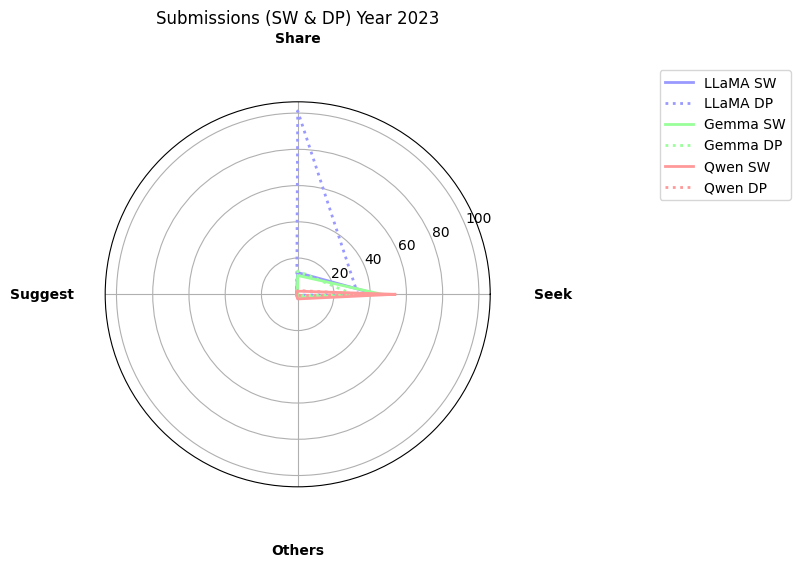

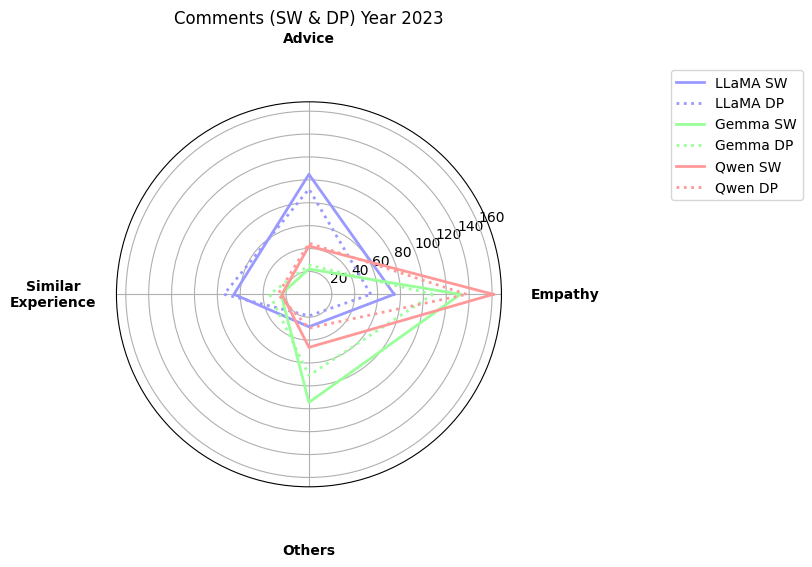

In [17]:
# 2023
# Data for submissions
categories_sub = ['Seek', 'Share', 'Suggest', 'Others']
data_sw_sub_2023 = [[43737, 12002, 693, 2223], [46435, 10394, 157, 1714], [53591, 1741, 775, 2548]]
data_dp_sub_2023 = [[33168, 101183, 512, 538], [30414, 12884, 184, 854], [40784, 2095, 787, 670]]
plot_radar_chart("Submissions (SW & DP) Year 2023", categories_sub, data_sw_sub_2023, data_dp_sub_2023, 'radar_charts/radar_submissions_2023.png')

# Data for comments
categories_com = ['Empathy', 'Advice', 'Similar Experience', 'Others']
data_sw_com_2023 = [[74468, 104860, 65551, 28356], [132284, 22114, 24390, 94447], [161084, 42188, 23615, 46348]]
data_dp_com_2023 = [[54046, 92056, 74192, 18863], [108354, 25610, 34330, 70863], [137656, 44757, 27164, 29580]]
plot_radar_chart("Comments (SW & DP) Year 2023", categories_com, data_sw_com_2023, data_dp_com_2023,'radar_charts/radar_comments_2023.png')

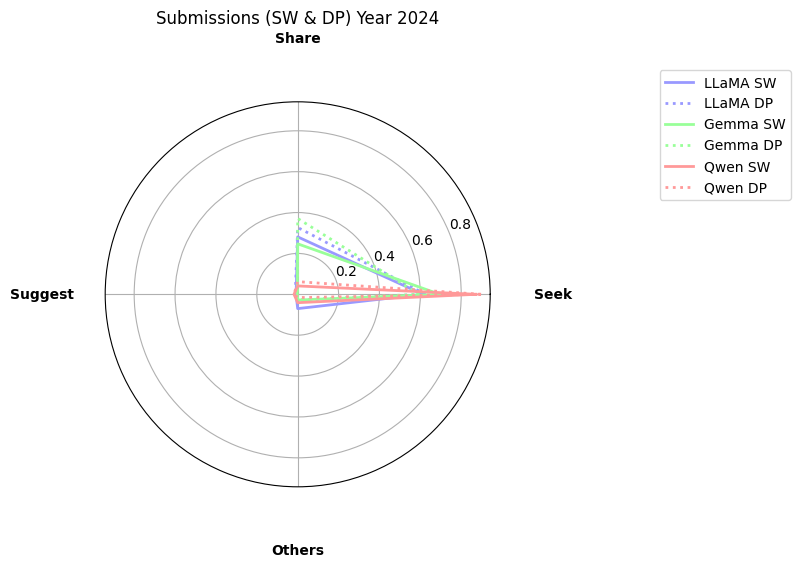

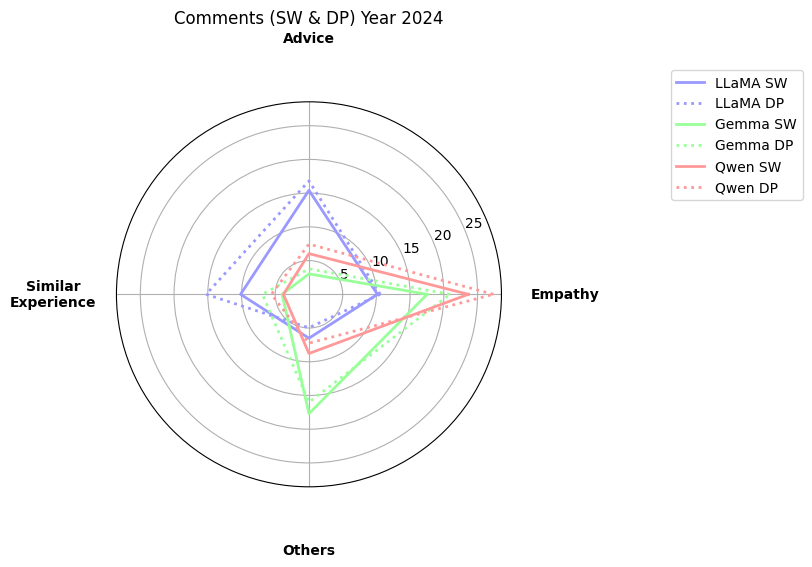

In [18]:
# 2024
# Data for submissions
categories_sub = ['Seek', 'Share', 'Suggest', 'Others']
data_sw_sub_2024 = [[613, 281, 8, 70], [695, 247, 2, 28], [872, 41, 18, 41]]
data_dp_sub_2024 = [[625, 327, 12, 29], [594, 371, 1, 27], [897, 62, 18, 16]]
plot_radar_chart("Submissions (SW & DP) Year 2024", categories_sub, data_sw_sub_2024, data_dp_sub_2024, 'radar_charts/radar_submissions_2024.png')

# Data for comments
categories_com = ['Empathy', 'Advice', 'Similar Experience', 'Others']
data_sw_com_2024 = [[10156, 15421, 10141, 6511], [17525, 3028, 3979, 17697], [23631, 6035, 3785, 8778]]
data_dp_com_2024 = [[10564, 16815, 15249, 4960], [20906, 3776, 6902, 16004], [27328, 7448, 5569, 7243]]
plot_radar_chart("Comments (SW & DP) Year 2024", categories_com, data_sw_com_2024, data_dp_com_2024,'radar_charts/radar_comments_2024.png')